## Introduction

The goal of this EDA analysis is to understand booking patterns and identify key drivers of cancellations in hotel booking data. This will guide predictive modeling and support business insights.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/processed/hotel_booking_clean.csv')

## Cancellation Overview

We compare cancellation vs. check-out rates across the two hotels.

In [27]:
# Group by hotel and count outcomes
cancellation_summary = df.groupby('hotel').agg(
    Total_Bookings=('is_canceled', 'count'),
    Check_Out=('is_canceled', lambda x: (x == 0).sum()),   # not canceled
    Canceled=('is_canceled', lambda x: (x == 1).sum())     # canceled
).reset_index()

# Add percentages
cancellation_summary['% Check-Out'] = cancellation_summary['Check_Out'] / cancellation_summary['Total_Bookings'] * 100
cancellation_summary['% Canceled'] = cancellation_summary['Canceled'] / cancellation_summary['Total_Bookings'] * 100

# Display neatly
cancellation_summary.round(2)

,hotel,Total_Bookings,Check_Out,Canceled,% Check-Out,% Canceled
0,City Hotel,52678,37377,15301,70.95,29.05
1,Resort Hotel,33696,25986,7710,77.12,22.88


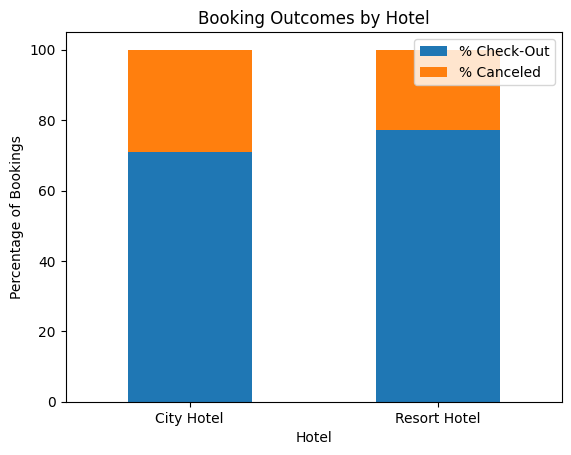

In [29]:
# Plot stacked bar of % check-out vs % canceled
cancellation_df = cancellation_summary.set_index("hotel")[["% Check-Out", "% Canceled"]]

ax = cancellation_df.plot(
    kind="bar",
    stacked=True
)

plt.title("Booking Outcomes by Hotel")
plt.ylabel("Percentage of Bookings")
plt.xlabel("Hotel")
plt.legend(loc="upper right")
plt.xticks(rotation=0)
plt.show()

We can see that the Resort Hotel has a noticeably higher cancellation rate compared to the City Hotel, indicating higher booking volatility in resort stays.

## Guest Demographics & Groups

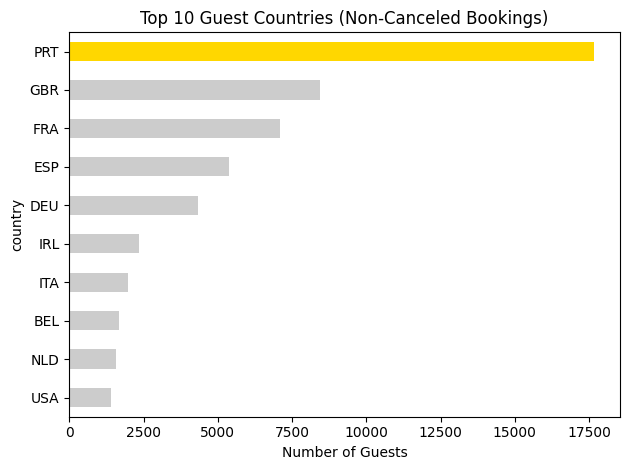

In [37]:
country_wise_guests = df[df['is_canceled'] == 0]['country'].value_counts().reset_index()
country_wise_guests.columns = ['country', 'No of guests']

top10 = country_wise_guests.head(10)
colors = ["#FFD700"] + ["#CCCCCC"] * 9  # gold for top, gray for rest
top10.plot(kind="barh", x="country", y="No of guests", color=colors, legend=False)
plt.gca().invert_yaxis()
plt.title("Top 10 Guest Countries (Non-Canceled Bookings)")
plt.xlabel("Number of Guests")
plt.tight_layout()
plt.show()


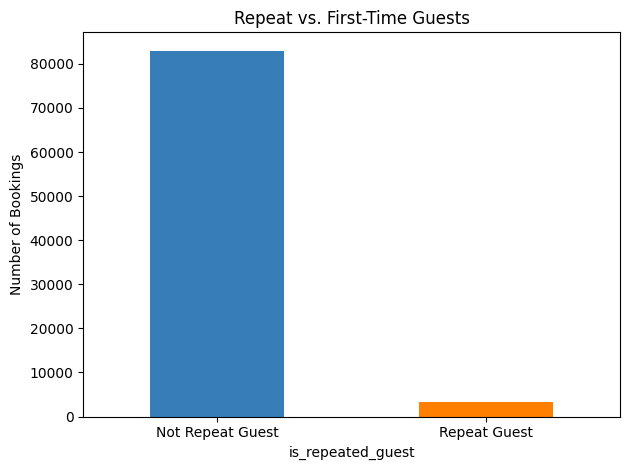

In [58]:
repeat_guest_dist = df['is_repeated_guest'].map({0: 'Not Repeat Guest', 1: 'Repeat Guest'}).value_counts()

repeat_guest_dist.plot(kind='bar', color=["#377eb8", "#ff7f00"])
plt.ylabel('Number of Bookings')
plt.title('Repeat vs. First-Time Guests')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


* Guest demand is led by Portugal, with the UK and Spain following behind.
* Repeat guests make up only a small share, highlighting weak retention. 

## Booking Characteristics

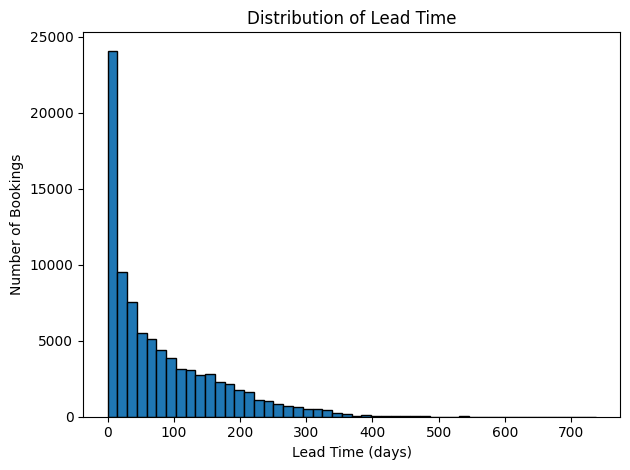

In [ ]:
# Distribution of Lead Time (days)
df['lead_time'].plot(kind='hist', bins=50, edgecolor='black')
plt.xlabel('Lead Time (days)')
plt.ylabel('Number of Bookings')
plt.title('Distribution of Lead Time')
plt.tight_layout()
plt.show()

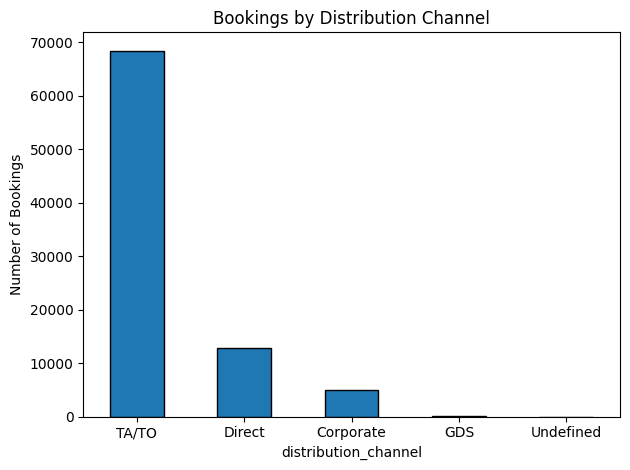

In [59]:
# Bookings by distribution channel
df['distribution_channel'].value_counts().plot(kind='bar',edgecolor="black")
plt.ylabel("Number of Bookings")
plt.title("Bookings by Distribution Channel")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


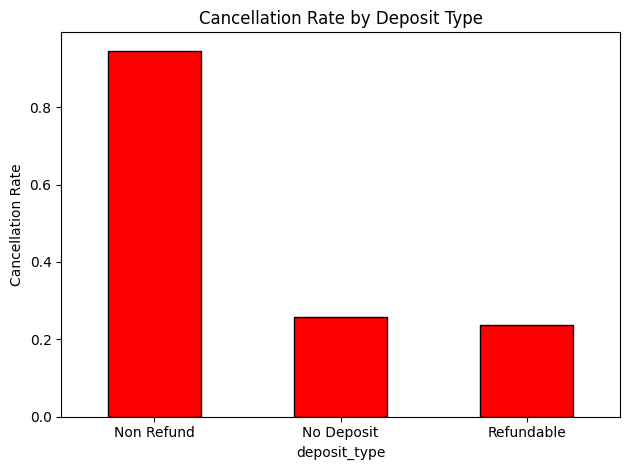

In [62]:
# Cancellation rate by deposit type
deposit_cancel_rate = (df.groupby('deposit_type')['is_canceled'].mean().sort_values(ascending=False))

ax = deposit_cancel_rate.plot(kind='bar', color="red", edgecolor="black")
plt.ylabel("Cancellation Rate")
plt.title("Cancellation Rate by Deposit Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

* Most bookings are made well in advance, often through travel agents or tour operators.  
* Deposit type is strongly linked to cancellation behavior: non-refundable deposits have the highest cancellation rate, while refundable and no-deposit bookings are less likely to be canceled.  

Although counterintuitive, non-refundable bookings in this dataset show the highest cancellation rates. This may reflect fraudulent or invalid credit card reservations, speculative over-booking through OTAs (e.g., guests or agents making multiple reservations), or cancellations of business and group blocks that had prepaid deposits, rather than guests willingly forfeiting large payments.

## Seasonality & Time Patterns

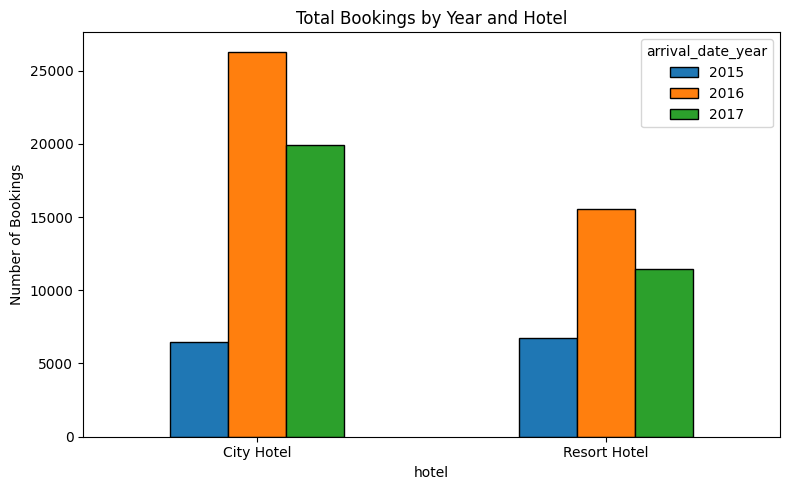

In [ ]:
# Yearly total bookings per hotel
yearly_bookings = df.groupby(['hotel', 'arrival_date_year']).size().unstack()

yearly_bookings.plot(kind='bar', figsize=(8,5), edgecolor="black")
plt.ylabel("Number of Bookings")
plt.title("Total Bookings by Year and Hotel")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


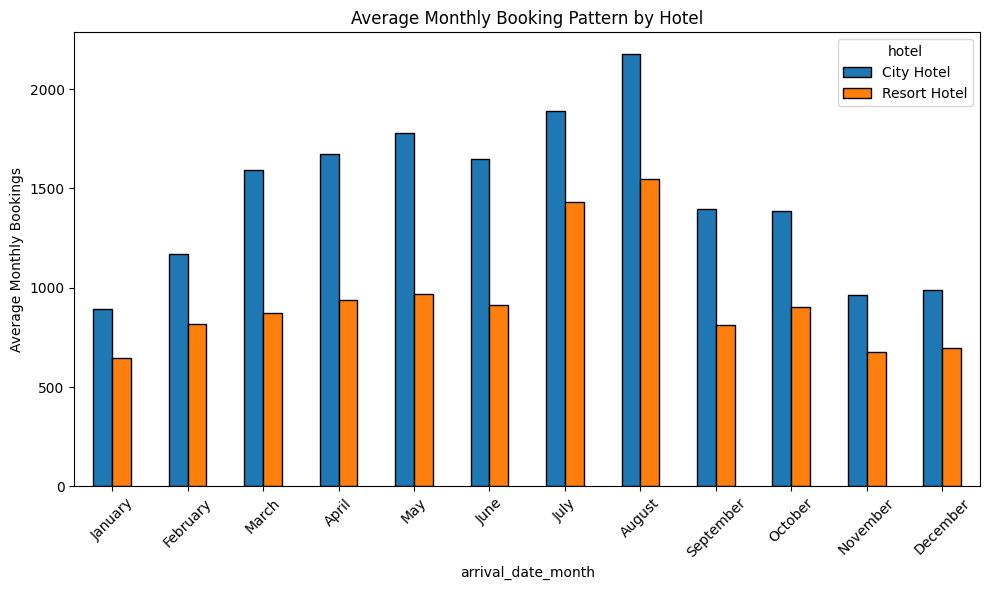

In [47]:
# Average monthly bookings per hotel
monthly_order = ['January','February','March','April','May','June','July',
                 'August','September','October','November','December']

monthly_avg = (
    df.groupby(['hotel','arrival_date_month']).size()
    .div(df['arrival_date_year'].nunique())
    .unstack(level=0)
    .reindex(monthly_order)
)

monthly_avg.plot(kind='bar', figsize=(10,6), edgecolor="black")
plt.ylabel("Average Monthly Bookings")
plt.title("Average Monthly Booking Pattern by Hotel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



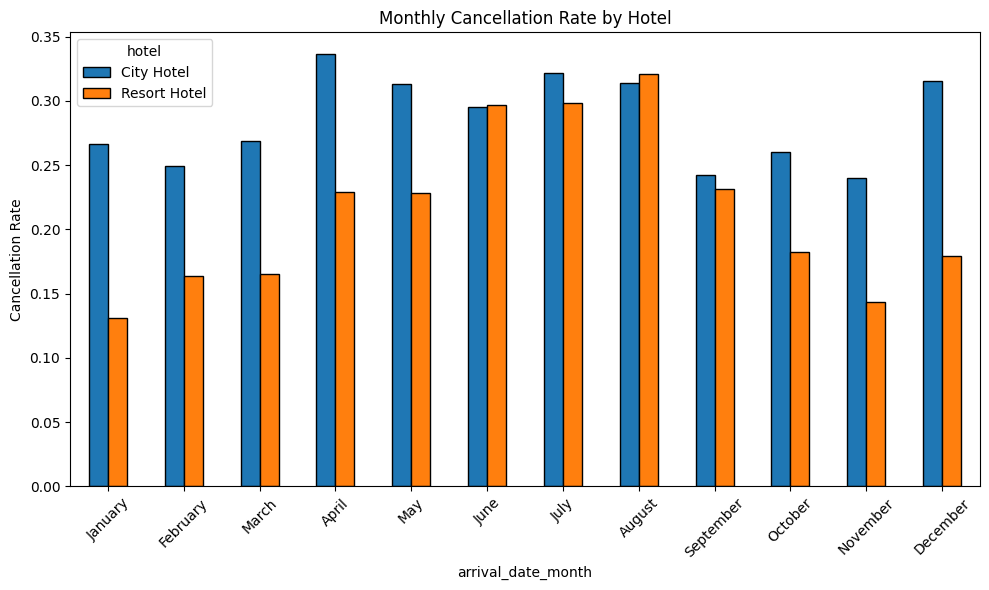

In [48]:
# Monthly cancellation rate per hotel
monthly_cancel_rate = (
    df.groupby(['hotel','arrival_date_month'])['is_canceled']
    .mean()
    .unstack(level=0)
    .reindex(monthly_order)
)

monthly_cancel_rate.plot(kind='bar', figsize=(10,6), edgecolor="black")
plt.ylabel("Cancellation Rate")
plt.title("Monthly Cancellation Rate by Hotel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



* **Booking trends:** City Hotel consistently attracts more bookings overall, while Resort Hotel shows stronger seasonality with sharp summer peaks.  
* **Cancellation patterns:** Cancellation rates rise during high-demand months, with City Hotel generally higher throughout the year and Resort Hotel spiking in peak season.  


## Financial & Revenue Insights  

In [64]:
# Estimate capacity from maximum observed occupancy
df["nights"] = df["stays_in_week_nights"] + df["stays_in_weekend_nights"]

all_stays = []
for _, row in df.iterrows():
    for i in range(row["nights"]):
        all_stays.append({
            "hotel": row["hotel"],
            "date": row["arrival_date"] + pd.Timedelta(days=i)
        })

stays = pd.DataFrame(all_stays)
stays["year"] = stays["date"].dt.year

max_occ = stays.groupby(["hotel", "year"])["date"].value_counts().groupby(level=[0,1]).max()
capacity_per_hotel = max_occ.groupby("hotel").max().to_dict()
print("Estimated Capacity per Hotel:")
capacity_per_hotel


Estimated Capacity per Hotel:


{'City Hotel': 372, 'Resort Hotel': 320}

We estimate hotel capacity from maximum observed occupancy: ~372 rooms for City Hotel and ~320 rooms for Resort Hotel. This capacity baseline allows us to compare performance fairly using RevPAR.


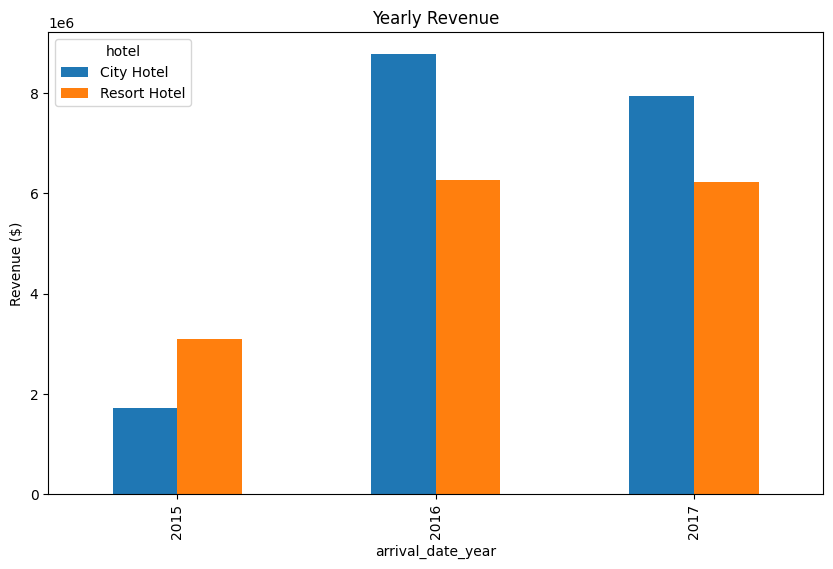

In [ ]:
# Compute revenue per booking
df["room_revenue"] = df["adr"] * df["nights"]

# Yearly revenue per hotel
yearly_revenue = (
    df.groupby(["hotel", "arrival_date_year"])["room_revenue"]
      .sum()
      .unstack(level=0)   # puts City/Resort as columns
)

yearly_revenue_df = pd.DataFrame(yearly_revenue)
yearly_revenue_df.index = yearly_revenue_df.index.astype(int)
yearly_revenue_df.plot(kind='bar', figsize=(10,6), title="Yearly Revenue")
plt.ylabel("Revenue ($)")
plt.show()

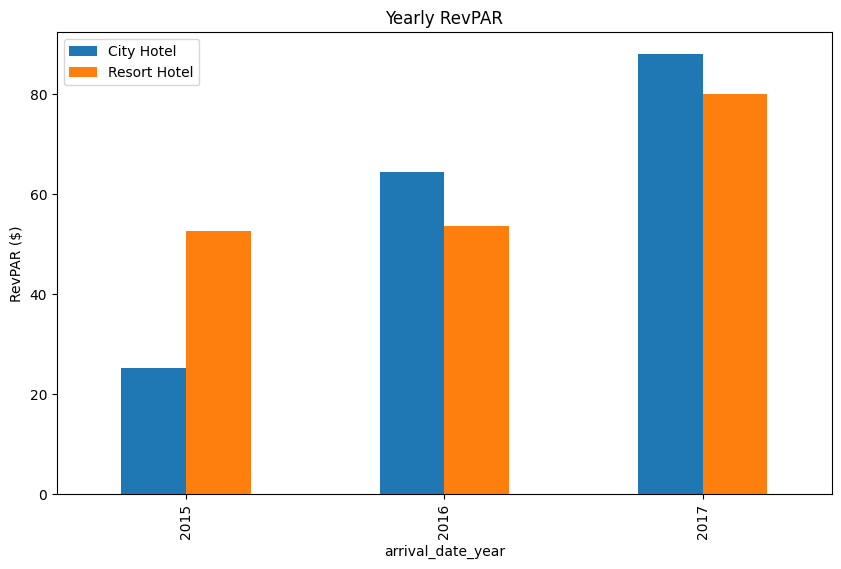

In [ ]:
# Yearly RevPAR per hotel (warning-free)
yearly_revpar = {}

for hotel_name, hotel_df in df.groupby("hotel"):
    capacity = capacity_per_hotel[hotel_name]

    revpar_per_year = (
        hotel_df.groupby("arrival_date_year")
        .agg(total_revenue=("room_revenue", "sum"),
             num_days=("arrival_date", lambda x: x.dt.normalize().nunique()))
    )
    revpar_per_year = revpar_per_year["total_revenue"] / (capacity * revpar_per_year["num_days"])

    yearly_revpar[hotel_name] = revpar_per_year

yearly_revpar_df = pd.DataFrame(yearly_revpar)
yearly_revpar_df.index = yearly_revpar_df.index.astype(int)

yearly_revpar_df.plot(kind='bar', figsize=(10,6), title="Yearly RevPAR")
plt.ylabel("RevPAR ($)")
plt.show()

* **City Hotel:** Revenue peaked in 2016 and dipped in 2017, but RevPAR continued to rise. This suggests higher room rates compensated for fewer rooms sold.  
* **Resort Hotel:** Revenue grew steadily year over year, with RevPAR showing strong acceleration between 2016 and 2017 — reflecting both rising prices and strong occupancy.  


In [ ]:
# Monthly Revenue and RevPAR
monthly_revenue = {}
monthly_revpar = {}

for hotel_name, hotel_df in df.groupby("hotel"):
    capacity = capacity_per_hotel[hotel_name]
    hotel_df = hotel_df.copy()
    hotel_df["year_month"] = hotel_df["arrival_date"].dt.to_period("M")

    rev_month = {}
    revpar_month = {}
    for ym, g in hotel_df.groupby("year_month"):
        total_revenue = g["room_revenue"].sum()
        num_days = g["arrival_date"].dt.normalize().nunique()
        available_room_nights = capacity * num_days
        rev_month[str(ym)] = total_revenue
        revpar_month[str(ym)] = total_revenue / available_room_nights

    monthly_revenue[hotel_name] = rev_month
    monthly_revpar[hotel_name] = revpar_month

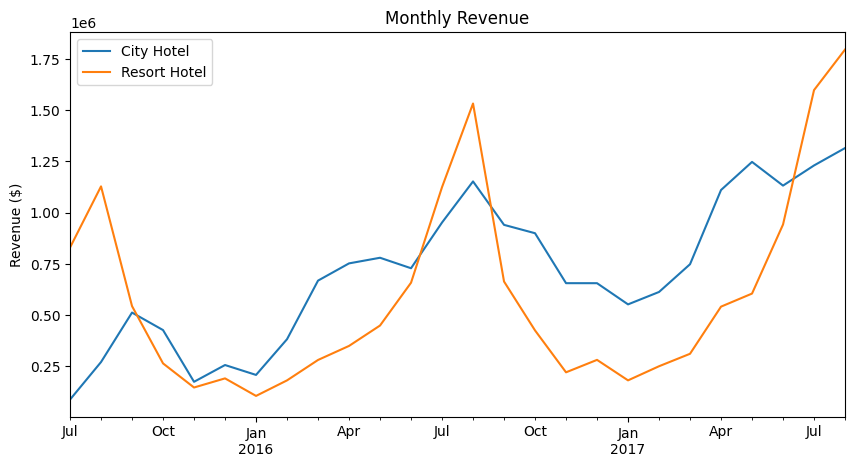

In [53]:
# Monthly Revenue plot
monthly_revenue_df = pd.DataFrame(monthly_revenue)
monthly_revenue_df.index = pd.to_datetime(monthly_revenue_df.index.astype(str))

monthly_revenue_df.plot(figsize=(10,5), title="Monthly Revenue")
plt.ylabel("Revenue ($)")
plt.show()


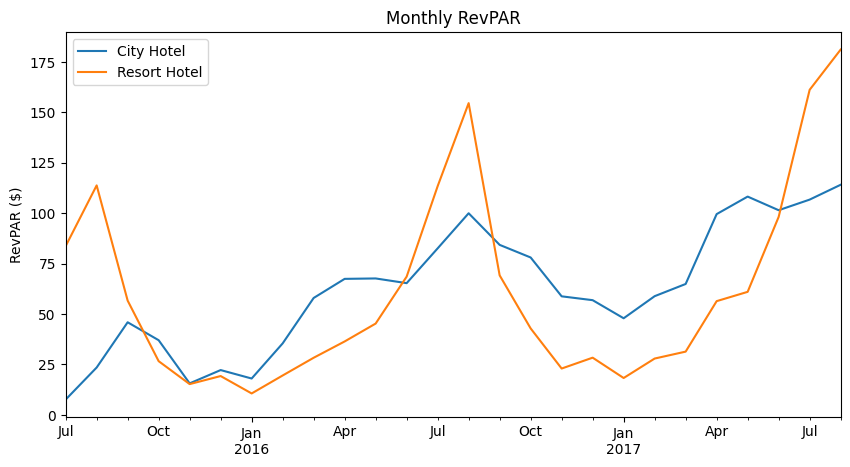

In [54]:
# Monthly RevPAR plot
monthly_revpar_df = pd.DataFrame(monthly_revpar)
monthly_revpar_df.index = pd.to_datetime(monthly_revpar_df.index.astype(str))

monthly_revpar_df.plot(figsize=(10,5), title="Monthly RevPAR")
plt.ylabel("RevPAR ($)")
plt.show()


* **City Hotel:** Revenue and RevPAR remain relatively steady with mild seasonality, showing resilience across months.  
* **Resort Hotel:** Strong seasonality is evident, with sharp summer peaks and deep winter troughs, making performance highly dependent on seasonal demand.  



## Correlation Analysis

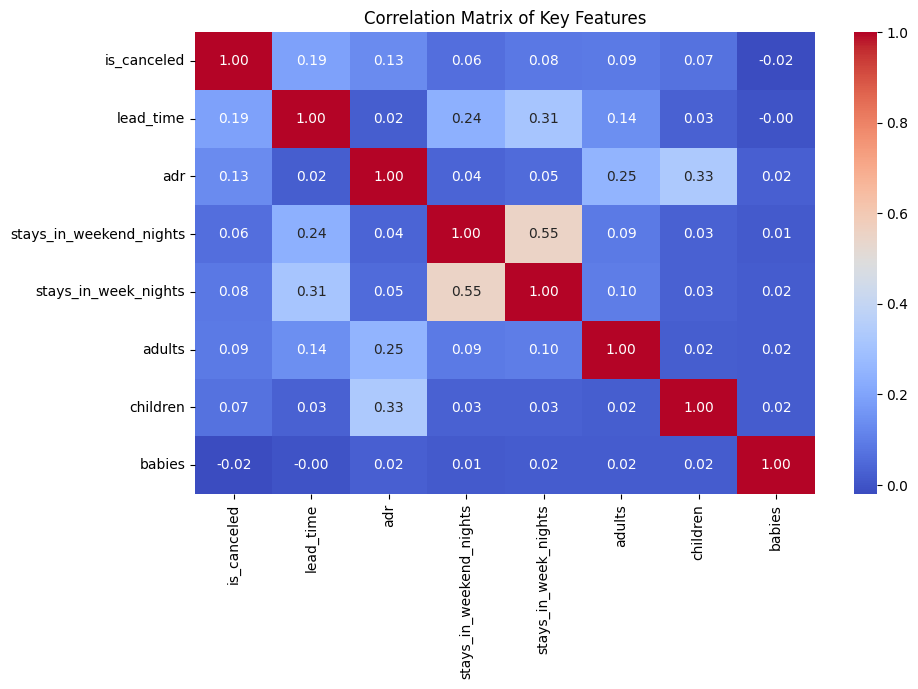

In [55]:
import seaborn as sns

# Select numerical columns of interest
corr_cols = [
    'is_canceled', 'lead_time', 'adr', 'stays_in_weekend_nights',
    'stays_in_week_nights', 'adults', 'children', 'babies'
]

corr = df[corr_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Matrix of Key Features")
plt.show()


* Cancellations rise with longer lead times (corr = 0.19).  
* Larger groups tend to book more expensive rooms (ADR corr with children = 0.33, adults = 0.25).  

## Summary

This exploratory analysis reveals several patterns in hotel bookings:  

- **Cancellations:** More common at Resort Hotels and strongly associated with longer lead times.  
- **Guest profile:** Demand is dominated by domestic guests (Portugal), mostly adult groups. Repeat guests account for only a small fraction.  
- **Booking behavior:** Travel agents and tour operators handle most bookings. Non-refundable deposits show the highest cancellation rates.  
- **Seasonality:** Resort Hotels experience sharp summer peaks, while City Hotels maintain steadier demand year-round.  
- **Financials:** City Hotel’s revenue plateaued after 2016, though RevPAR rose due to higher rates. Resort Hotel benefited from both rising occupancy and higher prices, especially in summer.  
- **Correlations:** Lead time is the strongest predictor of cancellations. ADR is moderately associated with group size (larger groups book pricier rooms).  

**Key drivers of cancellations and revenue** include lead time, booking channel, deposit type, and seasonality. These insights will inform feature selection and hypotheses for modeling.  
